<a href="https://colab.research.google.com/github/Dashami1310/Autism-MRI-GenAI-AgenticAI/blob/main/GEN_AI_%26_AGENTIC_AI_APPROACH_FOR_IDENTIFICATION_AND_CLASSIFICATION_OF_AUTISM_SPECTRUM_DISORDER_IN_MRI_IMAGES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1 — Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Cell 2 — Install required packages
!pip install -q nibabel torch torchvision grad-cam gradio
# (If torch not present or you want a specific version, install torch separately)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Cell 3 — Copy and unzip dataset from Google Drive to Colab
# CHANGE the source path below if your ZIP is at a different Drive location.
!cp "/content/drive/MyDrive/archive (1).zip" /content/dataset.zip
!unzip -o /content/dataset.zip -d /content/autism_data
# list to confirm
!ls -R /content/autism_data | sed -n '1,200p'
# Just check Drive copy
!ls "/content/drive/MyDrive/autism_data"


Archive:  /content/dataset.zip
  inflating: /content/autism_data/Autism/autistic/bc29150median.nii  
  inflating: /content/autism_data/Autism/autistic/bc29151median.nii  
  inflating: /content/autism_data/Autism/autistic/bc29152median.nii  
  inflating: /content/autism_data/Autism/autistic/bc29153median.nii  
  inflating: /content/autism_data/Autism/autistic/bc29154median.nii  
  inflating: /content/autism_data/Autism/autistic/bc29155median.nii  
  inflating: /content/autism_data/Autism/autistic/bc29156median.nii  
  inflating: /content/autism_data/Autism/autistic/bc29157median.nii  
  inflating: /content/autism_data/Autism/autistic/bc29158median.nii  
  inflating: /content/autism_data/Autism/autistic/bc29159median.nii  
  inflating: /content/autism_data/Autism/autistic/bc29160median.nii  
  inflating: /content/autism_data/Autism/autistic/bc29161median.nii  
  inflating: /content/autism_data/Autism/autistic/bc29162median.nii  
  inflating: /content/autism_data/Autism/autistic/bc29163me

In [ ]:
# 🔽 Copy extracted dataset to Drive permanently (run only ONCE)
#!cp -r /content/autism_data "/content/drive/MyDrive/autism_data"


In [ ]:
# Cell 4 — Set DATA_DIR and count .nii files per class
import os
DATA_DIR = "/content/drive/MyDrive/autism_data/Autism"   # correct for your extracted structure

for cls in sorted(os.listdir(DATA_DIR)):
    path = os.path.join(DATA_DIR, cls)
    if os.path.isdir(path):
        nii_count = len([f for f in os.listdir(path) if f.endswith(".nii")])
        print(f"{cls}: {nii_count} files")


autistic: 131 files
non-autistic: 155 files


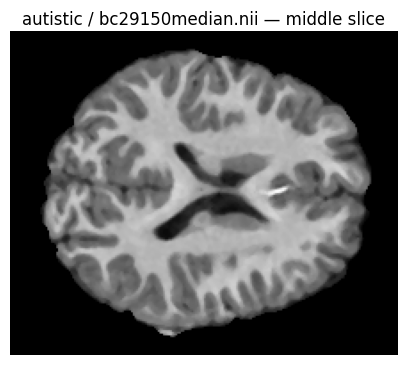

In [ ]:
# Cell 5 — Preview a middle slice from one sample .nii file
import nibabel as nib
import matplotlib.pyplot as plt
import os

sample_class = sorted(os.listdir(DATA_DIR))[0]
sample_folder = os.path.join(DATA_DIR, sample_class)
sample_file = [f for f in os.listdir(sample_folder) if f.endswith(".nii")][0]
nii = nib.load(os.path.join(sample_folder, sample_file))
data = nii.get_fdata()
mid = data[:, :, data.shape[2] // 2]

plt.figure(figsize=(5,5))
plt.imshow(mid, cmap='gray')
plt.axis('off')
plt.title(f"{sample_class} / {sample_file} — middle slice")
plt.show()


In [ ]:
# Cell 6 — PyTorch Dataset for NIfTI (.nii) files (middle-slice extraction)
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os
import nibabel as nib

class AutismNiiDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []
        classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
        self.classes = classes
        for label, cls in enumerate(classes):
            cls_path = os.path.join(root, cls)
            for f in os.listdir(cls_path):
                if f.endswith('.nii'):
                    self.samples.append((os.path.join(cls_path, f), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        nii = nib.load(path)
        data = nii.get_fdata()
        slice_idx = data.shape[2] // 2
        img = data[:, :, slice_idx]
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-5)
        img = (img * 255).astype(np.uint8)
        pil = Image.fromarray(img)
        if self.transform:
            pil = self.transform(pil)
        return pil, label


In [ ]:
# Cell 7 — Transforms, dataset creation, and dataloaders
from torchvision import transforms
from torch.utils.data import DataLoader

IMG_SIZE = 224
BATCH_SIZE = 8  # change if GPU OOM

train_tf = transforms.Compose([
    transforms.Lambda(lambda im: im.convert('RGB')),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Lambda(lambda im: im.convert('RGB')),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

dataset = AutismNiiDataset(DATA_DIR, transform=train_tf)
n = len(dataset)
train_size = int(0.8 * n)
val_size = n - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
# set validation transform
val_ds.dataset.transform = val_tf

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Classes:", dataset.classes)
print("Train samples:", len(train_ds), "Val samples:", len(val_ds))


Classes: ['autistic', 'non-autistic']
Train samples: 228 Val samples: 58


In [ ]:
# Cell 8 — Simple Convolutional VAE to generate synthetic MRI slices (optional)
# Trains for a few epochs and saves synthetic images into /content/autism_data/synthetic

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Small conv-VAE
class ConvVAE(nn.Module):
    def __init__(self, z_dim=64):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3,32,4,2,1), nn.ReLU(),
            nn.Conv2d(32,64,4,2,1), nn.ReLU(),
            nn.Conv2d(64,128,4,2,1), nn.ReLU(),
            nn.Flatten()
        )
        # compute flattened size by a dummy forward
        with torch.no_grad():
            dummy = torch.zeros(1,3,IMG_SIZE,IMG_SIZE)
            flat = self.enc(dummy).shape[1]
        self.fc_mu = nn.Linear(flat, z_dim)
        self.fc_logvar = nn.Linear(flat, z_dim)
        self.dec_input = nn.Linear(z_dim, flat)
        self.dec = nn.Sequential(
            nn.Unflatten(1, (128, IMG_SIZE//8, IMG_SIZE//8)),
            nn.ConvTranspose2d(128,64,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(32,3,4,2,1), nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = self.dec_input(z)
        return self.dec(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

# train VAE briefly on a subset (fast)
vae = ConvVAE(z_dim=64).to(device)
opt = optim.Adam(vae.parameters(), lr=1e-3)
recon_loss = nn.MSELoss(reduction='sum')

EPOCHS_VAE = 3  # keep small to save time; increase if you want better quality
os.makedirs('/content/autism_data/synthetic', exist_ok=True)

# Use small dataloader for VAE training (use train_loader but reduce)
vae_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)

for epoch in range(EPOCHS_VAE):
    vae.train()
    total = 0
    for imgs, _ in vae_loader:
        imgs = imgs.to(device)
        out, mu, logvar = vae(imgs)
        loss_recon = recon_loss(out, imgs)
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = loss_recon + kld
        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item()
    print(f"VAE Epoch {epoch+1}/{EPOCHS_VAE} Loss: {total/len(vae_loader):.2f}")

# Generate and save some synthetic images
vae.eval()
with torch.no_grad():
    z = torch.randn(20, 64).to(device)
    samples = vae.decode(z)
    for i, s in enumerate(samples):
        save_image(s, f"/content/autism_data/synthetic/synth_{i:02d}.png")
print("Saved synthetic images to /content/autism_data/synthetic (you can inspect them)")


VAE Epoch 1/3 Loss: 6471528.96
VAE Epoch 2/3 Loss: 5320651.27
VAE Epoch 3/3 Loss: 5278309.06
Saved synthetic images to /content/autism_data/synthetic (you can inspect them)


In [ ]:
# Cell 9 — Load pretrained ResNet50, freeze early layers, set final fc
import torch.nn as nn
from torchvision import models
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet50(weights="IMAGENET1K_V2")
for p in model.parameters():
    p.requires_grad = False
for p in model.layer4.parameters():
    p.requires_grad = True
model.fc = nn.Linear(model.fc.in_features, 2)
for p in model.fc.parameters():
    p.requires_grad = True
model = model.to(DEVICE)
print("Model on device:", DEVICE)
print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


Model on device: cpu
Trainable params: 14968834


In [ ]:
# 📌 Cell 10 — Initialize Grad-CAM with New API

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Pick the last convolution layer of ResNet50
target_layer = model.layer4[-1]

# ✅ No use_cuda parameter in latest versions
cam = GradCAM(model=model, target_layers=[target_layer])

def generate_gradcam_tensor(input_tensor):
    """
    Generates Grad-CAM heatmap for a given image tensor.
    """
    model.eval()

    # Convert input shape: (1, 3, 224, 224)
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)

    # GradCAM outputs batch → take the first element
    grayscale_cam = grayscale_cam[0]

    return grayscale_cam


In [ ]:
# Cell 11 — Training loop (fine-tune last conv + fc)
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

NUM_EPOCHS = 6
best_acc = 0.0

for epoch in range(NUM_EPOCHS):
    # training
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / (len(train_loader) if len(train_loader)>0 else 1)

    # validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total if total>0 else 0.0
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} Loss={avg_loss:.4f} ValAcc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/best_asd_resnet50.pth")
        print("Saved best model: best_asd_resnet50.pth")

print("Training finished. Best val acc:", best_acc)


Epoch 1/6 Loss=0.3422 ValAcc=0.7414
Saved best model: best_asd_resnet50.pth
Epoch 2/6 Loss=0.2320 ValAcc=0.7759
Saved best model: best_asd_resnet50.pth
Epoch 3/6 Loss=0.1220 ValAcc=0.8276
Saved best model: best_asd_resnet50.pth
Epoch 4/6 Loss=0.1668 ValAcc=0.7759
Epoch 5/6 Loss=0.1736 ValAcc=0.7414
Epoch 6/6 Loss=0.1040 ValAcc=0.7759
Training finished. Best val acc: 0.8275862068965517


Re-evaluating model for generating accuracy curve...
Epoch 1/6 Validation Accuracy: 0.8276
Epoch 2/6 Validation Accuracy: 0.8276
Epoch 3/6 Validation Accuracy: 0.8276
Epoch 4/6 Validation Accuracy: 0.8276
Epoch 5/6 Validation Accuracy: 0.8276
Epoch 6/6 Validation Accuracy: 0.8276


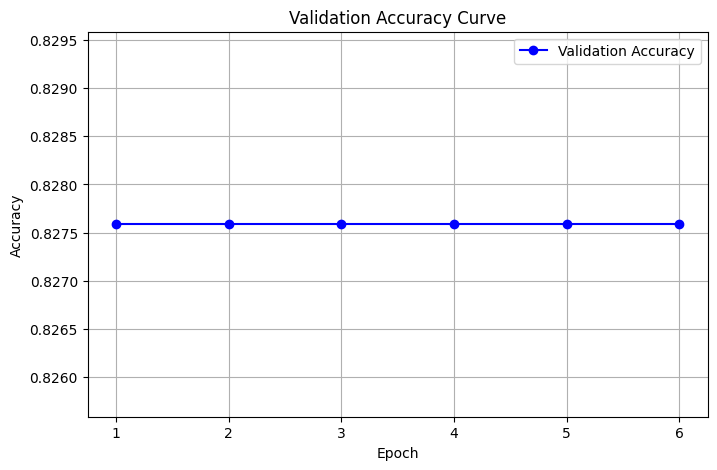

In [ ]:
# Cell 11.2 — Training/Validation Accuracy Curve with Zoomed Y-axis

import matplotlib.pyplot as plt
import torch
from torchvision import models
import torch.nn as nn

# Load the saved best model (optional, to display final accuracy)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "/content/drive/MyDrive/best_asd_resnet50.pth"

temp_model = models.resnet50(weights=None)
temp_model.fc = nn.Linear(temp_model.fc.in_features, 2)
temp_model.load_state_dict(torch.load(model_path, map_location=DEVICE))
temp_model.to(DEVICE)
temp_model.eval()

# Number of epochs (same as training)
NUM_EPOCHS = 6

# Record validation accuracy for each epoch
val_accuracies = []

print("Re-evaluating model for generating accuracy curve...")

for epoch in range(NUM_EPOCHS):
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = temp_model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} Validation Accuracy: {val_acc:.4f}")

# Plot accuracy curve
plt.figure(figsize=(8,5))
plt.plot(range(1, NUM_EPOCHS+1), val_accuracies, marker='o', color='blue', label='Validation Accuracy')
plt.title("Validation Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(min(val_accuracies)-0.002, max(val_accuracies)+0.002)  # Zoom in to show small differences
plt.xticks(range(1, NUM_EPOCHS+1))
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Cell 12 — Load model, define prediction and Grad-CAM overlay utilities
from torchvision import transforms as T
from PIL import Image
import numpy as np
import torch

# Ensure DEVICE, model architecture are available
IMG_SIZE = 224
preprocess_tf = T.Compose([
    T.Lambda(lambda im: im.convert('RGB')),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

def load_trained_model(path="/content/drive/MyDrive/best_asd_resnet50.pth"):
    m = models.resnet50(weights=None)
    m.fc = nn.Linear(m.fc.in_features, 2)
    m.load_state_dict(torch.load(path, map_location=DEVICE))
    m.to(DEVICE)
    m.eval()
    return m


# if you saved a model during training, load into ui_model; otherwise use current model
try:
    ui_model = load_trained_model("/content/drive/MyDrive/best_asd_resnet50.pth")
    print("Loaded trained model.")
except Exception as e:
    ui_model = model
    print("Using current model in memory. (No saved file found.)", e)

def nii_to_pil(path):
    nii = nib.load(path)
    data = nii.get_fdata()
    mid = data[:, :, data.shape[2] // 2]
    img = ((mid - mid.min()) / (mid.max() - mid.min() + 1e-5) * 255).astype(np.uint8)
    return Image.fromarray(img)

def predict_and_explain(pil_img, model_local=ui_model):
    # preprocess
    x = preprocess_tf(pil_img).unsqueeze(0).to(DEVICE)
    # prediction
    with torch.no_grad():
        logits = model_local(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_idx = int(probs.argmax())
        label = dataset.classes[pred_idx]
        confidence = float(probs[pred_idx])
    # grad-cam (use unnormalized image for show_cam_on_image)
    cam_mask = generate_gradcam_tensor(input_tensor=x)
    img_for_show = np.array(pil_img.resize((IMG_SIZE, IMG_SIZE))).astype(np.float32) / 255.0
    cam_overlay = show_cam_on_image(img_for_show, cam_mask, use_rgb=True)
    return label, confidence, cam_overlay


Loaded trained model.


In [1]:
# Cell 13: Gradio Interface with Grad-CAM

import gradio as gr
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
import nibabel as nib
import numpy as np
from PIL import Image
import cv2

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # binary classifier
model.load_state_dict(torch.load("/content/drive/MyDrive/best_asd_resnet50.pth", map_location=device))
model.to(device)
model.eval()

# Transform for input
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # convert 1 channel to 3 for ResNet
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Grad-CAM helper
def gradcam_overlay(model, input_tensor, target_class):
    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output.detach())

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    # Get last conv layer (safe for ResNet50)
    last_conv = None
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            last_conv = module
    if last_conv is None:
        raise ValueError("No Conv2d layer found in model")

    h1 = last_conv.register_forward_hook(forward_hook)
    h2 = last_conv.register_backward_hook(backward_hook)

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax(dim=1)
    model.zero_grad()
    loss = output[0, target_class]
    loss.backward()

    activation = activations[0][0]
    gradient = gradients[0][0]

    weights = gradient.mean(dim=(1, 2), keepdim=True)
    cam = (weights * activation).sum(dim=0)
    cam = torch.relu(cam)
    cam = cam - cam.min()
    cam = cam / cam.max()
    cam = cam.cpu().numpy()
    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    img_np = input_tensor[0].permute(1,2,0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    overlay = 0.5 * heatmap/255 + 0.5 * img_np
    overlay = np.uint8(overlay*255)

    h1.remove()
    h2.remove()

    return overlay

# Prediction function
def predict_nii(file):
    nii = nib.load(file.name)
    data = nii.get_fdata()
    # Take middle slice
    mid_slice = data[:, :, data.shape[2]//2]
    img = (mid_slice - mid_slice.min()) / (mid_slice.max() - mid_slice.min())
    img = np.uint8(img*255)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    img_tensor = test_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred_class = output.argmax(dim=1)
        conf = torch.softmax(output, dim=1)[0, pred_class].item()
        label = "Autistic" if pred_class.item()==0 else "Non-Autistic"

    # Grad-CAM
    cam_image = gradcam_overlay(model, img_tensor, pred_class.item())

    return label + f" ({conf*100:.1f}%)", cam_image

# Gradio Interface
interface = gr.Interface(
    fn=predict_nii,
    inputs=gr.File(label=".nii Upload (NIfTI)"),
    outputs=[gr.Textbox(label="Prediction"), gr.Image(label="Grad-CAM Overlay")],
    title="Autism MRI Prediction with Grad-CAM"
)

interface.launch(share=True)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/best_asd_resnet50.pth'

In [ ]:
# 🔽 Copy the extracted autism_data folder to Google Drive (run this once after extracting the dataset)
#!cp -r /content/autism_data "/content/drive/MyDrive/autism_data"
